# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations
In this basic set up , we only do Image Normalisation

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


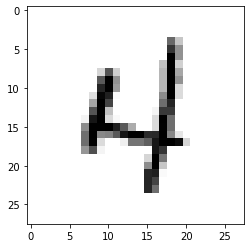

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## More Visualizations

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

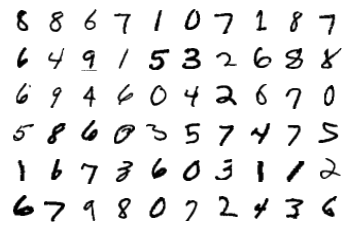

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with basic squueze and expand model

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #conv block 1
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) # 28>28 | 3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 28 > 28 |  5

        #transition block 1
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(2, 2) # 28 > 14 | 10

        #conv block 2 
        self.conv4 = nn.Conv2d(10, 16, 3, padding=1) # 14> 14 | 12
        self.conv5 = nn.Conv2d(16, 32, 3, padding=1) #14 > 14 | 14

        #transition block 2
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        self.pool2 = nn.MaxPool2d(2, 2) # 14 > 7 | 28

        #conv block 1
        self.conv7 = nn.Conv2d(10, 16, 3) # 7 > 5 | 30
        self.conv8 = nn.Conv2d(16, 32, 3) # 5 > 3 | 32 | 3*3*1024 | 3x3x1024x10 | 

        self.conv9 = nn.Conv2d(32, 10, 3) # 3 > 1 | 34 | > 1x1x10

    def forward(self, x):
        x = self.pool1(self.conv3(F.relu(self.conv2(F.relu(self.conv1(x))))))
        x = self.pool2(self.conv6((F.relu(self.conv5(F.relu(self.conv4(x)))))))
        x = F.relu(self.conv8(F.relu(self.conv7(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv9(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 28, 28]           4,640
            Conv2d-3           [-1, 10, 28, 28]             320
         MaxPool2d-4           [-1, 10, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           1,456
            Conv2d-6           [-1, 32, 14, 14]           4,640
            Conv2d-7           [-1, 10, 14, 14]             320
         MaxPool2d-8             [-1, 10, 7, 7]               0
            Conv2d-9             [-1, 16, 5, 5]           1,456
           Conv2d-10             [-1, 32, 3, 3]           4,640
           Conv2d-11             [-1, 10, 1, 1]           2,890
Total params: 20,522
Trainable params: 20,522
Non-trainable par

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [14]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.9786980152130127 Batch_id=468 Accuracy=14.94: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]



Test set: Average loss: 0.7005, Accuracy: 7857/10000 (78.57%)

EPOCH: 1


Loss=0.1652883142232895 Batch_id=468 Accuracy=92.52: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]



Test set: Average loss: 0.1114, Accuracy: 9634/10000 (96.34%)

EPOCH: 2


Loss=0.05388779938220978 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]



Test set: Average loss: 0.0793, Accuracy: 9741/10000 (97.41%)

EPOCH: 3


Loss=0.0495486706495285 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]



Test set: Average loss: 0.0514, Accuracy: 9822/10000 (98.22%)

EPOCH: 4


Loss=0.13357146084308624 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]



Test set: Average loss: 0.0548, Accuracy: 9807/10000 (98.07%)

EPOCH: 5


Loss=0.015773842111229897 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]



Test set: Average loss: 0.0459, Accuracy: 9847/10000 (98.47%)

EPOCH: 6


Loss=0.06351496279239655 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]



Test set: Average loss: 0.0404, Accuracy: 9868/10000 (98.68%)

EPOCH: 7


Loss=0.01019330881536007 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]



Test set: Average loss: 0.0406, Accuracy: 9865/10000 (98.65%)

EPOCH: 8


Loss=0.05790919065475464 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]



Test set: Average loss: 0.0395, Accuracy: 9858/10000 (98.58%)

EPOCH: 9


Loss=0.08684098720550537 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]



Test set: Average loss: 0.0355, Accuracy: 9892/10000 (98.92%)

EPOCH: 10


Loss=0.023683466017246246 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]



Test set: Average loss: 0.0362, Accuracy: 9884/10000 (98.84%)

EPOCH: 11


Loss=0.05312228575348854 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]



Test set: Average loss: 0.0339, Accuracy: 9894/10000 (98.94%)

EPOCH: 12


Loss=0.0035086777061223984 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]



Test set: Average loss: 0.0373, Accuracy: 9881/10000 (98.81%)

EPOCH: 13


Loss=0.05821904540061951 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]



Test set: Average loss: 0.0389, Accuracy: 9883/10000 (98.83%)

EPOCH: 14


Loss=0.01698603294789791 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]



Test set: Average loss: 0.0364, Accuracy: 9892/10000 (98.92%)



In [15]:
import numpy as np
[t.cpu().item() for t in train_losses]

[2.3021504878997803,
 2.3068931102752686,
 2.305393695831299,
 2.3018434047698975,
 2.308320999145508,
 2.3035993576049805,
 2.302041530609131,
 2.29860520362854,
 2.3037524223327637,
 2.3021175861358643,
 2.304394245147705,
 2.305882692337036,
 2.3015387058258057,
 2.3055646419525146,
 2.304703712463379,
 2.3073971271514893,
 2.3028030395507812,
 2.304453134536743,
 2.3038244247436523,
 2.3033711910247803,
 2.3071467876434326,
 2.30330753326416,
 2.303795337677002,
 2.303760051727295,
 2.3033576011657715,
 2.3023524284362793,
 2.303739070892334,
 2.3032095432281494,
 2.3037848472595215,
 2.301852226257324,
 2.302171230316162,
 2.3024871349334717,
 2.3037095069885254,
 2.304751396179199,
 2.3032360076904297,
 2.301506757736206,
 2.3019919395446777,
 2.299656391143799,
 2.3020401000976562,
 2.3034558296203613,
 2.3021163940429688,
 2.298319101333618,
 2.3005735874176025,
 2.303659439086914,
 2.3029122352600098,
 2.3048360347747803,
 2.301020860671997,
 2.306743621826172,
 2.303027153015

NameError: ignored

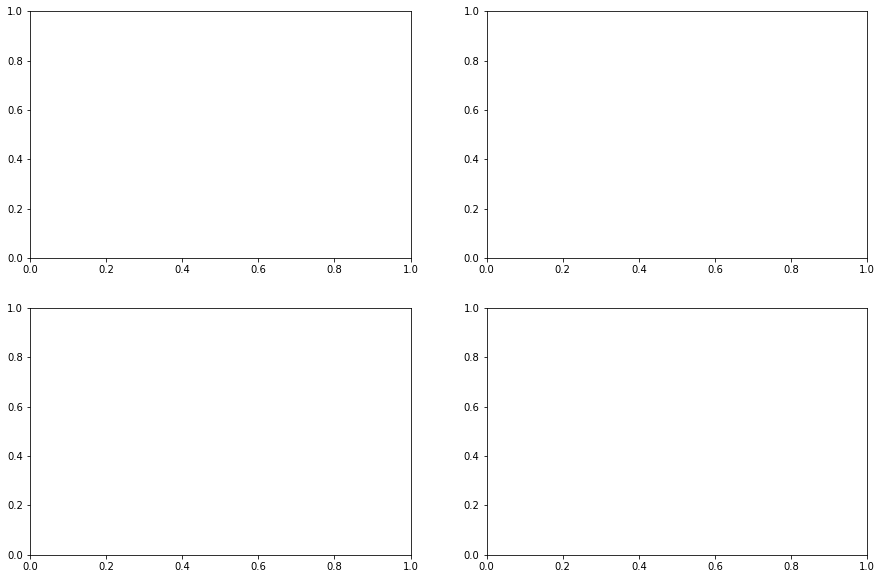

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")